In [11]:
import pandas
import io
import uuid
import datetime
import pathlib
from fabric import Connection
import os
cur_dir=os.getcwd() # save current directory to save the generated CSV files
print(cur_dir)




C:\Users\Camil\OneDrive\Documents\masters\memoire\flinkImplemProject\src\main\python


In [12]:
location = "lille"
node = "chifflot-1"
c1 = Connection(host='ccaulier@access.grid5000.fr')
# print(c1.run("hostname"))
c2 = Connection(host='ccaulier@{}'.format(location), gateway=c1)
# print(c2.run("hostname"))
c = Connection(host='ccaulier@{}'.format(node), gateway=c2)

In [13]:
import time
def runExperiment(main_parallelism,notebook_dir, dataFileDirectory, remote_output_file, local_output_file, remote_throughput_file, local_throughput_file):
    c.run("./flink-1.18.1/bin/start-cluster.sh")
    c.run("bash runPrometheusAndFlink.sh {} {}".format(main_parallelism, dataFileDirectory))
    print("python fakePrometheus.py > throughput.dat &")
    print("running flink jobs")
    time.sleep(5)
    c.get(remote_output_file, "%s/%s" % (notebook_dir, local_output_file))
    c.get(remote_throughput_file, "%s/%s" % (notebook_dir, local_throughput_file))
    c.run("flink-1.18.1/bin/stop-cluster.sh")
    

In [33]:
experimentName = "mean_50"
experimentDirectory = "%s/experiments/experiment_%s/" % (cur_dir,experimentName)
dataDirectory = "data50" 
# pathlib.Path(experimentDirectory).mkdir(exist_ok=True, parents=True)
n_experiments = 5
main_parallelism = 10


In [34]:
# for i in range(n_experiments):
#     print("Experiment %s" % i)
#     currentExperimentDirectory = "%s%s" % ( experimentDirectory, i )
#     pathlib.Path(currentExperimentDirectory).mkdir(exist_ok=True, parents=True)
#
#     runExperiment(main_parallelism, currentExperimentDirectory, dataDirectory, "output.dat", "output.dat", "throughput.dat", "throughput.dat")

In [83]:
import pandas as pd
import re

def parse_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    metric_pattern = re.compile(r'^metric:(.+)$')
    runtime_pattern = re.compile(r'Job Runtime: (\d+) ms')

    data = []
    current_runtime = None  # To store runtime for next metric entry

    for line in lines:
        runtime_match = runtime_pattern.search(line)
        if runtime_match:
            current_runtime = int(runtime_match.group(1))

        metric_match = metric_pattern.match(line)
        if metric_match and current_runtime is not None:
            metric_data = metric_match.group(1).split(',')
            csv_source = metric_data[5].split("_")
            # print(csv_source)
            csv_source[5] = csv_source[5].replace(".csv", "")
            if(csv_source[5] == "1.0E-15"):
                csv_source[5] = "0.0"
            # print(csv_source)
            csv_source.remove("distribution")
            for val in csv_source:
                metric_data.append(val)

            metric_data.append(current_runtime)  # Append the runtime to metric data
            data.append(metric_data)
            current_runtime = None  # Reset runtime after adding to data

    # Define DataFrame column names
    column_names = ['Operator', 'Duration', 'MainParallelism', 'HybridParallelism', 'Choices', 'CSVSource','distributionType','eventPerWindow','keySize','amountOfWindows','skew', 'Runtime (ms)']
    # Create DataFrame
    df = pd.DataFrame(data, columns=column_names)
    return df

def save_dataframe_to_csv(df, output_path):
    df.to_csv(output_path, index=False)


# n_experiments = 3
main_df =pd.DataFrame()
for i in range(n_experiments):
    
    experimentFile = "%s%s/output.dat" % ( experimentDirectory, i )
    print(experimentFile)
    df= parse_data(experimentFile)
    save_dataframe_to_csv(df,"%s%s/output.csv" % ( experimentDirectory, i ))
    main_df = pd.concat([main_df, df], ignore_index=True)
# main_df.to_csv(main_df)

C:\Users\Camil\OneDrive\Documents\masters\memoire\flinkImplemProject\src\main\python/experiment_mean_50/0/output.dat
C:\Users\Camil\OneDrive\Documents\masters\memoire\flinkImplemProject\src\main\python/experiment_mean_50/1/output.dat
C:\Users\Camil\OneDrive\Documents\masters\memoire\flinkImplemProject\src\main\python/experiment_mean_50/2/output.dat
C:\Users\Camil\OneDrive\Documents\masters\memoire\flinkImplemProject\src\main\python/experiment_mean_50/3/output.dat
C:\Users\Camil\OneDrive\Documents\masters\memoire\flinkImplemProject\src\main\python/experiment_mean_50/4/output.dat


In [85]:
main_df

,Operator,Duration,MainParallelism,HybridParallelism,Choices,CSVSource,distributionType,eventPerWindow,keySize,amountOfWindows,skew,Runtime (ms)
0,MeanBasic,20299,10,0,0,zipf_distribution_100000_3_50_1.4.csv,zipf,100000,3,50,1.4,18563
1,MeanBasic,13310,10,0,0,zipf_distribution_100000_2_50_1.0E-15.csv,zipf,100000,2,50,0.0,10860
2,MeanBasic,13236,10,0,0,zipf_distribution_100000_1_50_1.0E-15.csv,zipf,100000,1,50,0.0,11883
3,MeanBasic,13238,10,0,0,zipf_distribution_100000_2_50_0.7.csv,zipf,100000,2,50,0.7,11047
4,MeanBasic,13229,10,0,0,zipf_distribution_100000_3_50_0.35.csv,zipf,100000,3,50,0.35,10942
...,...,...,...,...,...,...,...,...,...,...,...,...
295,MeanHybrid,15284,5,5,0,zipf_distribution_100000_3_50_2.1.csv,zipf,100000,3,50,2.1,13050
296,MeanHybrid,15212,5,5,0,zipf_distribution_100000_2_50_1.4.csv,zipf,100000,2,50,1.4,14449
297,MeanHybrid,17242,5,5,0,zipf_distribution_100000_3_50_1.0E-15.csv,zipf,100000,3,50,0.0,15529
298,MeanHybrid,15242,5,5,0,zipf_distribution_100000_1_50_1.4.csv,zipf,100000,1,50,1.4,13761


In [86]:
import matplotlib.pyplot as plt

# Group data and calculate mean and range of runtime
main_df.drop(columns=['Duration'])
grouped = main_df.groupby(['Operator', 'MainParallelism', 'HybridParallelism', 'Choices', 'CSVSource','distributionType','eventPerWindow','keySize','amountOfWindows','skew'])
runtime_stats = grouped['Runtime (ms)'].agg(['mean', lambda x: x.max() - x.min()]).rename(columns={'<lambda_0>': 'range'}).reset_index()
# runtime_stats = grouped['Runtime (ms)'].agg(['mean', lambda x: x.max() - x.min()]).rename(columns={'<lambda_0>': 'range'})
runtime_stats['keySize']

0     1
1     1
2     1
3     1
4     1
5     2
6     2
7     2
8     2
9     2
10    3
11    3
12    3
13    3
14    3
15    1
16    1
17    1
18    1
19    1
20    2
21    2
22    2
23    2
24    2
25    3
26    3
27    3
28    3
29    3
30    1
31    1
32    1
33    1
34    1
35    2
36    2
37    2
38    2
39    2
40    3
41    3
42    3
43    3
44    3
45    1
46    1
47    1
48    1
49    1
50    2
51    2
52    2
53    2
54    2
55    3
56    3
57    3
58    3
59    3
Name: keySize, dtype: object

2    0.00
0    0.35
1    0.70
3    1.40
4    2.10
Name: skew, dtype: float64
17    0.00
15    0.35
16    0.70
18    1.40
19    2.10
Name: skew, dtype: float64
32    0.00
30    0.35
31    0.70
33    1.40
34    2.10
Name: skew, dtype: float64
47    0.00
45    0.35
46    0.70
48    1.40
49    2.10
Name: skew, dtype: float64
7    0.00
5    0.35
6    0.70
8    1.40
9    2.10
Name: skew, dtype: float64
22    0.00
20    0.35
21    0.70
23    1.40
24    2.10
Name: skew, dtype: float64
37    0.00
35    0.35
36    0.70
38    1.40
39    2.10
Name: skew, dtype: float64
52    0.00
50    0.35
51    0.70
53    1.40
54    2.10
Name: skew, dtype: float64
12    0.00
10    0.35
11    0.70
13    1.40
14    2.10
Name: skew, dtype: float64
27    0.00
25    0.35
26    0.70
28    1.40
29    2.10
Name: skew, dtype: float64
42    0.00
40    0.35
41    0.70
43    1.40
44    2.10
Name: skew, dtype: float64
57    0.00
55    0.35
56    0.70
58    1.40
59    2.10
Name: skew, dtype: float64


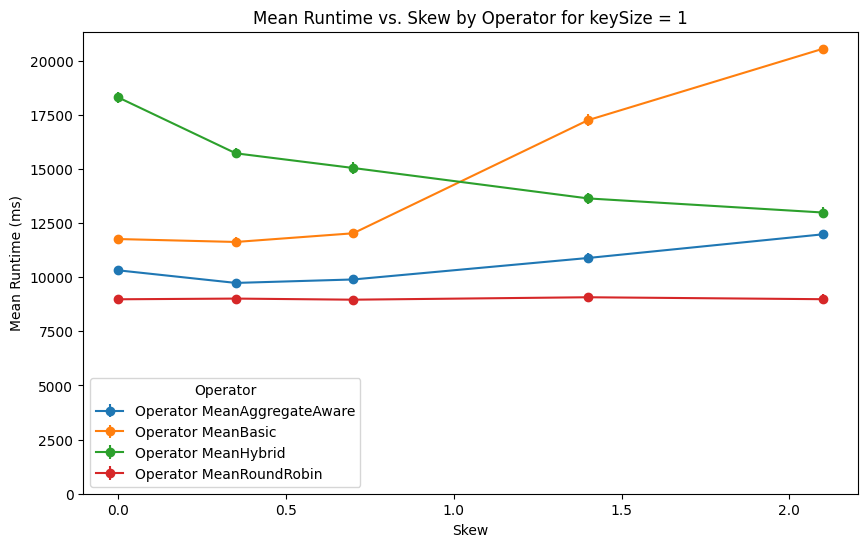

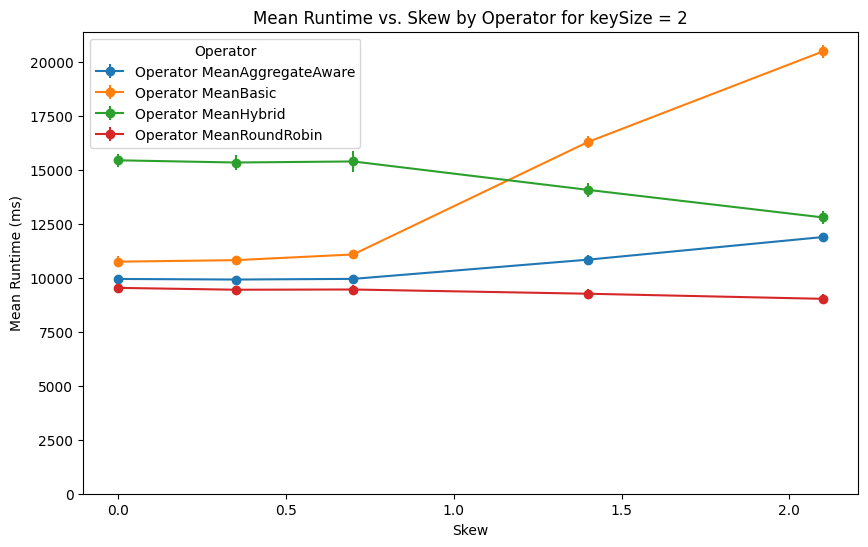

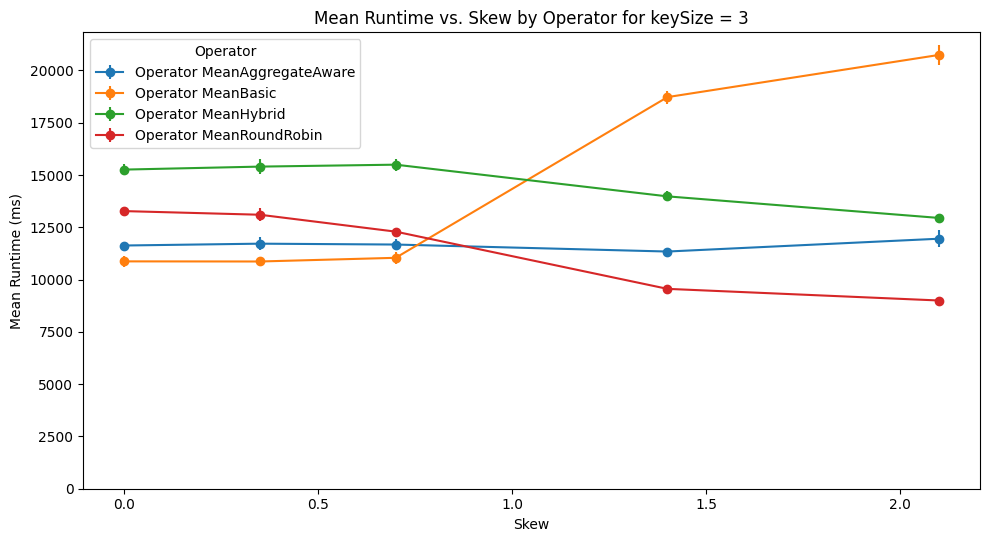

In [104]:

runtime_stats['skew'] = runtime_stats['skew'].astype(float)

sorted_runtime_stats = runtime_stats.sort_values(by='skew')
for i in range(1,3+1):
    keysize_2_data = runtime_stats[runtime_stats['keySize'] == str(i)].sort_values(by='skew')


    # Set up the plotting area
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot data for each operator
    for name, group in keysize_2_data.groupby('Operator'):
        if not group.empty:
            print(group['skew'])
            ax.errorbar(group['skew'], group['mean'], yerr=group['range']/2, fmt='-o', label=f'Operator {name}')
        else:
            print(f"No data for Operator {name} with keySize == {i}")

    # Label the axes and the plot
    ax.set_xlabel('Skew')
    ax.set_ylabel('Mean Runtime (ms)')
    ax.set_title('Mean Runtime vs. Skew by Operator for keySize = {}'.format(i))
    ax.legend(title='Operator')
     # Set the y-axis to start at 0
    ax.set_ylim(bottom=0)

    # Show the plot
    # plt.show()
    plt.savefig(experimentDirectory+"plot{}.png".format(i))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()



In [105]:
import pandas as pd

# Assume df is your DataFrame
main_df.to_csv(experimentDirectory+"dataframe.csv", index=False)